# Lab2. Custom object detection with SageMaker built-in algorithm

In this lab, you will build a model to recognize license plate area from images that we generated in Lab1.  
You can run all notebook cells at once **after changing the bucket name 'None' to yours** (Look for the "Change the bucket name")

In [1]:
import os 

## Divide train and valdiation data from gnenrated images

* prepare folder to store divided train/validation data

In [2]:
!rm -fR od
!mkdir od od/od-train od/od-train_annotation od/od-validation od/od-validation_annotation

In [3]:
jsons = os.listdir('gen/gen-tags')
print ('There are {:,} images have annotation files'.format(len(jsons)))

There are 10,000 images have annotation files


* Define the number of train/valdiation images

In [4]:
n_samples = len(jsons)
n_val = 5000 if n_samples > 25000 else round(n_samples * 0.2)
n_train = n_samples - n_val
print('{:,} images will be used for training, and {:,} images will be used for validation.'.format(n_train, n_val))

8,000 images will be used for training, and 2,000 images will be used for validation.


* Move images and annotation files to od-train and od-validation folders  
 (Cropped-imgs and nums-tags files are not moved.)

In [5]:
import shutil

train_jsons = jsons[:n_train]
val_jsons = jsons[n_train:]

#Moving training files to the training folders
for i in train_jsons:
    image_file = './gen/gen-imgs/'+i.split('.')[0]+'.png'
    shutil.move(image_file, './od/od-train/')
    shutil.move('./gen/gen-tags/'+i, './od/od-train_annotation/')

#Moving validation files to the validation folders
for i in val_jsons:
    image_file = './gen/gen-imgs/'+i.split('.')[0]+'.png'
    shutil.move(image_file, './od/od-validation/')
    shutil.move('./gen/gen-tags/'+i, './od/od-validation_annotation/')

* check the move result

In [6]:
print('there are {:,} files in gen/gen-imgs folder.'.format(len(os.listdir('gen/gen-imgs'))))
print('there are {:,} files in gen/gen-tags folder.'.format(len(os.listdir('gen/gen-tags'))))
print('there are {:,} files in od/od-train folder.'.format(len(os.listdir('od/od-train'))))
print('there are {:,} files in od/od-train_annotation folder.'.format(len(os.listdir('od/od-train_annotation'))))
print('there are {:,} files in od/od-validation folder.'.format(len(os.listdir('od/od-validation'))))
print('there are {:,} files in od/od-validation_annotation folder.'.format(len(os.listdir('od/od-validation_annotation'))))

there are 0 files in gen/gen-imgs folder.
there are 0 files in gen/gen-tags folder.
there are 8,000 files in od/od-train folder.
there are 8,000 files in od/od-train_annotation folder.
there are 2,000 files in od/od-validation folder.
there are 2,000 files in od/od-validation_annotation folder.


## Upload the data to S3

* Set up SageMaker

In [7]:
from PIL import Image
import json
import matplotlib.image as mpimg

In [8]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::308961792850:role/service-role/AmazonSageMaker-ExecutionRole-20180531T094549
CPU times: user 718 ms, sys: 49.1 ms, total: 767 ms
Wall time: 1.37 s


* **Make sure you change the bucket name None with your S3 bucket name**
* Choose the same region bucket of your SageMaker


In [14]:
### Change the bucket name
bucket = None ## set to your bucket name.
prefix = 'anpr'
assert bucket != None

* Upload files to S3
* It may take several minutes **(10~15 minutes for 10,000 images)**

In [15]:
%%time

train_channel = prefix + '/od/od-train'
validation_channel = prefix + '/od/od-validation'
train_annotation_channel = prefix + '/od/od-train_annotation'
validation_annotation_channel = prefix + '/od/od-validation_annotation'

sess.upload_data(path='od/od-train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='od/od-validation', bucket=bucket, key_prefix=validation_channel)
sess.upload_data(path='od/od-train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
sess.upload_data(path='od/od-validation_annotation', bucket=bucket, key_prefix=validation_annotation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

CPU times: user 1min 48s, sys: 6.17 s, total: 1min 54s
Wall time: 14min 40s


* Check upload results 

In [16]:
!aws s3 ls {bucket}/anpr/od/od-train/ |wc -l
!aws s3 ls {bucket}/anpr/od/od-train_annotation/ |wc -l
!aws s3 ls {bucket}/anpr/od/od-validation/ |wc -l
!aws s3 ls {bucket}/anpr/od/od-validation_annotation/ |wc -l

8000
8000
2000
2000


In [17]:
s3_output_location = 's3://{}/{}/od-output'.format(bucket, prefix)

## Training with built-in algorithm
* Prepare SageMaker built-in Object Detection algorithm container

In [18]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

433757028032.dkr.ecr.us-west-2.amazonaws.com/object-detection:latest


* Define Object Detection Estimator and Hyperparameters
* Refer to SageMaker Estimator API -> https://sagemaker.readthedocs.io/en/stable/estimators.html
* Note that we set parameters as below:
    * train_instance_type: ml.p3.2xlarge
    * **base_network: resnet-50**
    * **use_transfer_model: True**
    * epochs: 10
    * mini_batch_size: 64
    * learning_rate: 0.001
    

In [19]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode = 'File',
                                         output_path=s3_output_location,
                                         tags=[{"Key":"anpr","Value":"anpr-plate detection"}],
                                         sagemaker_session=sess)

In [20]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=1,
                             mini_batch_size=64,
                             epochs=10,
                             learning_rate=0.001,
                             lr_scheduler_step='10',
                             lr_scheduler_factor=0.1,
                             optimizer='adam',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=300,
                             label_width=350,
                             num_training_samples=n_train)

* Pass the channel of S3 paths as a dictionary to the Estimator
* Ref to Sessions -> https://sagemaker.readthedocs.io/en/stable/session.html#sagemaker.session.s3_input

In [21]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/png', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/png', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='application/json', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='application/json', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

* Start the training.
* **It may take 20~25 minutes.**

In [22]:
%%time
od_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: object-detection-2019-04-22-14-47-13-527


2019-04-22 14:47:13 Starting - Starting the training job...
2019-04-22 14:47:15 Starting - Launching requested ML instances......
2019-04-22 14:48:24 Starting - Preparing the instances for training...
2019-04-22 14:49:08 Downloading - Downloading input data..................
2019-04-22 14:52:13 Training - Training image download completed. Training in progress..
Docker entrypoint called with argument(s): train
[04/22/2019 14:52:16 INFO 139872073103168] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'momentum': u'0.9', u'num_training_samples': u'', u'optimize

## Inference Object Detection

* Deploy trained model to SageMaker endpoint
* You can add Elastic Inference(EI, adding GPU power) by using 'accelerator_type' parameter
* Refer to types of EI asselerator below:
    * https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/ei.html

In [23]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.c5.xlarge',
                                 accelerator_type='ml.eia1.medium')

INFO:sagemaker:Creating model with name: object-detection-2019-04-22-15-03-04-037
INFO:sagemaker:Creating endpoint with name object-detection-2019-04-22-14-47-13-527


---------------------------------------------------------------------------------------!

* Check the endpoint name

In [24]:
print(object_detector.endpoint)

object-detection-2019-04-22-14-47-13-527


* Define bounding box visualization function 

In [25]:
import matplotlib.pyplot as plt
def visualize_detection(img_file, dets, code, thresh=0.6):
        import random
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = x0 * width
            ymin = y0 * height
            xmax = x1 * width
            ymax = y1 * height
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            #if classes and len(classes) > cls_id:class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(code, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')

        plt.show()

* Test licence plate detection of 10 sample image 

In [26]:
test_imgs = os.listdir('od/od-validation')
threshold = 0.4

{'prediction': [[0.0, 0.9999656677246094, 0.12877541780471802, 0.27478736639022827, 0.8487433791160583, 0.7159954309463501]]}


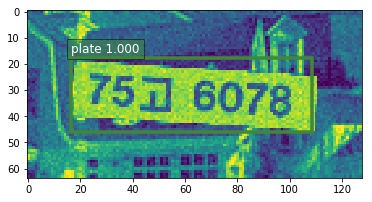

{'prediction': [[0.0, 0.9991770386695862, 0.24550986289978027, 0.33891355991363525, 0.7349100112915039, 0.6571431159973145], [0.0, 0.03449099138379097, 0.31432297825813293, 0.027040712535381317, 1.0, 0.23357686400413513]]}


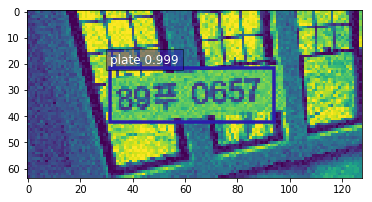

{'prediction': [[0.0, 0.9999463558197021, 0.13902202248573303, 0.20512664318084717, 0.8474504947662354, 0.7268980741500854]]}


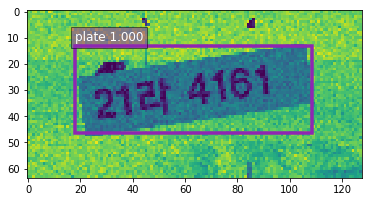

{'prediction': [[0.0, 0.9992954730987549, 0.010021388530731201, 0.20493313670158386, 0.9673529267311096, 0.7730292081832886]]}


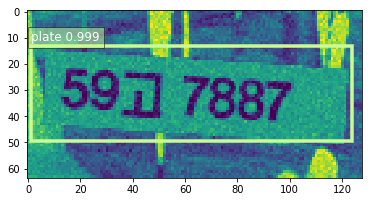

{'prediction': [[0.0, 0.9998548030853271, 0.1975017488002777, 0.32988929748535156, 0.7709388732910156, 0.6504030823707581]]}


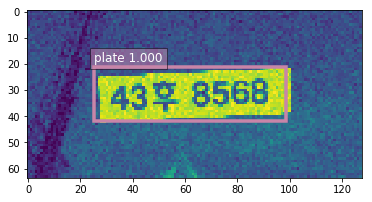

{'prediction': [[0.0, 0.9995829463005066, 0.021562546491622925, 0.10293951630592346, 0.9812629222869873, 0.8687549829483032]]}


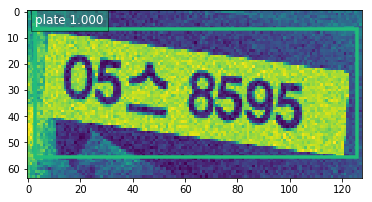

{'prediction': [[0.0, 0.9995274543762207, 0.20487335324287415, 0.33308500051498413, 0.7680572271347046, 0.6269527077674866]]}


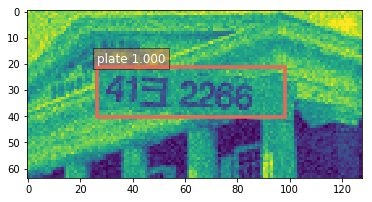

{'prediction': [[0.0, 0.9999381303787231, 0.1705821454524994, 0.25603604316711426, 0.8190581798553467, 0.673362135887146]]}


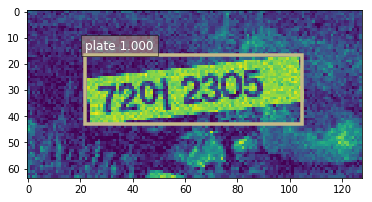

{'prediction': [[0.0, 0.9996082186698914, 0.15896886587142944, 0.3016866445541382, 0.7939662933349609, 0.7592666149139404]]}


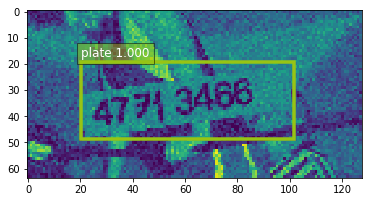

{'prediction': [[0.0, 0.9999459981918335, 0.1225307285785675, 0.2710227966308594, 0.8488250970840454, 0.7028445601463318]]}


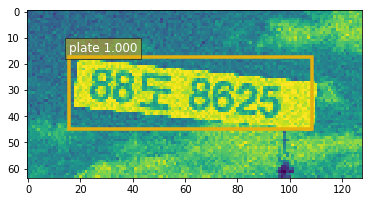

CPU times: user 2.19 s, sys: 2.92 s, total: 5.11 s
Wall time: 26.1 s


In [27]:
%%time
for i in test_imgs[:10]:
    ifile = 'od/od-validation/' + i
    with open(ifile, "rb") as image:
        f = image.read()
        b = bytearray(f)
        results = object_detector.predict(b)
        detections = json.loads(results)
        print(detections)
    visualize_detection(ifile, detections['prediction'], 'plate', threshold)

## Endpoint API test

* You can invoke SageMaker endpoint from business application as below:

In [28]:
import boto3
runtime = boto3.Session().client('runtime.sagemaker')

In [29]:
od_endpoint = object_detector.endpoint
response = runtime.invoke_endpoint(EndpointName=od_endpoint,
                                   ContentType='image/png',
                                   Body=b)
response['Body']

In [30]:
test_result = response['Body'].read()

In [31]:
print(json.loads(test_result)['prediction'])

[[0.0, 0.9999459981918335, 0.1225307285785675, 0.2710227966308594, 0.8488250970840454, 0.7028445601463318]]


## Delete endpoint

In [32]:
sagemaker.Session().delete_endpoint(object_detector.endpoint)

INFO:sagemaker:Deleting endpoint with name: object-detection-2019-04-22-14-47-13-527
